# Deep learning in genomics - Basic model in PyTorch

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [PyTorch](https://pytorch.org) library.

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
import pdb

In [5]:
# fastai version
__version__

'1.0.36.post1'

# Data setup

## Load data from the web, generate dataframe, and save to disk

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [67]:
seq_df.to_csv('seq_df.csv')

## Data frame setup

In [6]:
seq_df = pd.read_csv('seq_df.csv', index_col=0)

In [7]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


### Target setup

In [8]:
targA = seq_df['Target'].values; targA

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

In [9]:
targB = np.logical_not(seq_df['Target'].values).astype(int); targB

array([1, 1, 1, 0, ..., 0, 1, 0, 0])

In [10]:
targ = [[a,b] for a, b in zip(targA, targB)]; targ[:4], '...', targ[-4:]#, len(targ)

([[0, 1], [0, 1], [0, 1], [1, 0]], '...', [[1, 0], [0, 1], [1, 0], [1, 0]])

## Dataset setup for training with basic PyTorch

### Setup sqeuence to array function

In [11]:
def seq2array(seq:str)->List:
    "Return `List` object with np.array created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    return enc

In [12]:
# test open sequence function
test_arr = seq2array('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC'); test_arr, test_arr.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

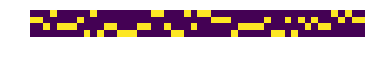

In [13]:
plt.imshow(test_arr)
plt.axis('off');

In [14]:
test_ten = tensor(test_arr).type(torch.float); test_ten

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
        [0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
# run test data through network
#net_basic(test_ten[None])

### Setup datasets

In [18]:
x = [tensor(seq2array(s)).type(torch.float) for s in seq_df['Sequences'].values]

In [19]:
x = torch.stack(x) # convert list to tensor

In [20]:
y = tensor(targ).view(-1,2).type(torch.float) # multi-label
#y = tensor(targA).type(torch.float) # classification with single label

In [21]:
y

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]])

In [22]:
len(x), len(y)

(2000, 2000)

In [23]:
# check data
i = 2
x[i], y[i]

(tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
          0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
          0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
          1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]),
 tensor([0., 1.]))

In [24]:
# split dataset
train_ds = TensorDataset(x[:1500],y[:1500])
valid_ds = TensorDataset(x[-500:],y[-500:])

In [25]:
# verify dataset length
len(train_ds), len(valid_ds)

(1500, 500)

# Model setup

## Basic model for PyTorch training

In [26]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [27]:
drop_p = 0.2

In [28]:
# inplace=True seems to generate problems?

In [29]:
net_basic = nn.Sequential(nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Dropout(drop_p),
                    nn.Linear(in_features=16, out_features=2),
                    #nn.Dropout(drop_p), # not at the end?
                    #Debugger()
                   )

In [30]:
# check network architecture
net_basic

Sequential(
  (0): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Lambda()
  (3): Dropout(p=0.2)
  (4): Linear(in_features=288, out_features=16, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2)
  (7): Linear(in_features=16, out_features=2, bias=True)
)

In [31]:
# initialize weights with kaiming normal initialization
apply_init(net_basic, nn.init.kaiming_normal_)

# Model training

## Train basic model with PyTorch

In [32]:
bs = 64

In [33]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2, shuffle=False)

In [34]:
opt = optim.SGD(net_basic.parameters(), lr=1e-3, momentum=0.9)

In [39]:
# Based on https://github.com/fastai/fastai_docs/blob/master/dev_nb/mnist_sample.py

def simple_loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def simple_fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    
    print('epoch\tvalid loss\taccuaracy')
    
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: simple_loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[simple_loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
            
            # calculations for accuracy_thres metric:          
            y_hat = [model(xb) for xb, _ in valid_dl]
            y_true = [yb for _, yb in valid_dl]
            
            
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        acc = accuracy_thresh(torch.cat(y_hat), torch.cat(y_true))
        
        print(f'{epoch}\t{val_loss:.6f}\t{acc.detach().item():.3f}')

In [37]:
simple_fit(50, net_basic, F.binary_cross_entropy_with_logits, opt, train_dl, valid_dl)

epoch	valid loss	accuaracy
0	0.710012	0.505
1	0.703077	0.510
2	0.700939	0.513
3	0.698251	0.512
4	0.696102	0.513
5	0.693986	0.512
6	0.692165	0.518
7	0.690641	0.521
8	0.689450	0.530
9	0.688368	0.540
10	0.687466	0.536
11	0.686810	0.545
12	0.685839	0.538
13	0.685121	0.549
14	0.684100	0.552
15	0.683149	0.558
16	0.681999	0.557
17	0.680665	0.563
18	0.679613	0.572
19	0.678567	0.572
20	0.677542	0.574
21	0.676188	0.577
22	0.674627	0.585
23	0.672909	0.589
24	0.671355	0.596
25	0.669761	0.597
26	0.667705	0.605
27	0.665524	0.608
28	0.662876	0.618
29	0.660283	0.624
30	0.657738	0.627
31	0.655253	0.639
32	0.652261	0.643
33	0.649530	0.647
34	0.646289	0.652
35	0.642831	0.652
36	0.639471	0.664
37	0.635668	0.668
38	0.631745	0.684
39	0.626921	0.683
40	0.622384	0.693
41	0.617400	0.696
42	0.612644	0.698
43	0.607735	0.701
44	0.603251	0.709
45	0.598561	0.712
46	0.593756	0.716
47	0.587313	0.725
48	0.582501	0.730
49	0.577269	0.738


In [38]:
simple_fit(50, net_basic, F.binary_cross_entropy_with_logits, opt, train_dl, valid_dl)

epoch	valid loss	accuaracy
0	0.572716	0.734
1	0.566159	0.740
2	0.559743	0.735
3	0.554389	0.747
4	0.549438	0.759
5	0.542842	0.757
6	0.535252	0.760
7	0.530050	0.768
8	0.523602	0.769
9	0.518245	0.769
10	0.512541	0.786
11	0.505102	0.780
12	0.498263	0.786
13	0.491942	0.794
14	0.485357	0.789
15	0.480438	0.796
16	0.474322	0.796
17	0.469184	0.796
18	0.463878	0.802
19	0.458933	0.804
20	0.454965	0.798
21	0.448350	0.808
22	0.443405	0.806
23	0.437890	0.808
24	0.432120	0.809
25	0.426829	0.806
26	0.422368	0.811
27	0.417588	0.812
28	0.413429	0.810
29	0.408779	0.812
30	0.403708	0.819
31	0.397934	0.819
32	0.392267	0.819
33	0.388548	0.825
34	0.383624	0.828
35	0.379232	0.826
36	0.374408	0.833
37	0.370561	0.835
38	0.366764	0.844
39	0.360998	0.843
40	0.356411	0.846
41	0.352707	0.846
42	0.347352	0.846
43	0.343324	0.850
44	0.340974	0.855
45	0.337862	0.854
46	0.332786	0.856
47	0.328492	0.859
48	0.323078	0.860
49	0.319277	0.866
